# Classificació amb SVM sobre el corpus Iris

Seguint l'exemple inicial, per fer la classificació de lliris, anem a veure ...


## Punt de partida. Classificador binari.

Podem fer ús d'un classificador binari per tal de distingir dues classes. El que hem vist a la unitat ha consistit en definir un classificador que disingisca les *Iris Setosa* de la resta. 

El codi per a això ha estat el següent:

In [1]:
# Importem el corpus i les llibreries
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# Carreguem el corpus Iris com a DataFrame
iris=load_iris(as_frame=True)

# I ens quedem només amb l'alt i ample dels pètals
X=iris.data[["petal length (cm)", "petal width (cm)"]].values

# Classifiquem només les "Iris Setosa"
# Per a això, posem True quan iris.target val 0 (0-Setosa, 1 Versicolor, 2 Virginica
Y=(iris.target == 0)

# Creem una pipeline per realitzar primer un escalat estàndard
# i després aplicar un SVC linial amb l'hiperparàmetre de 
# regularització C=1.
# El paràmetre dual=true s'a d'especificar pe evitar un warning.
classificador_svm=make_pipeline(StandardScaler(),
                               LinearSVC(C=1, random_state=42, dual=True))

# Entrenem el model amb les dades
classificador_svm.fit(X, Y)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, dual=True, random_state=42))])

In [2]:
# Classifiquem tres exemples

punts_nous=[[2.5, 0.4], [4, 1.5], [6, 2.5]]

classificador_svm.predict(punts_nous)

array([ True, False, False])

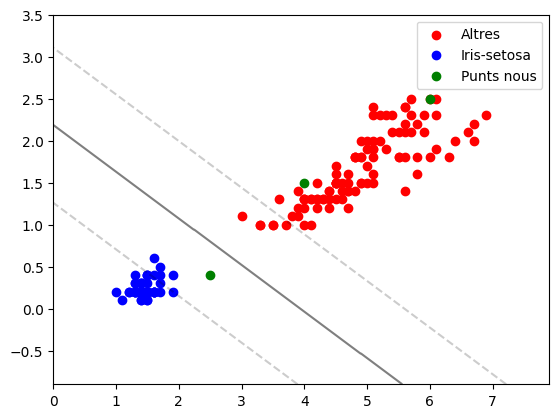

In [3]:
# I els representem gràficament

import numpy as np
import matplotlib.pyplot as plt

# Creem una graella de punts per a evaluar el model
x0, x1 = np.meshgrid(
        np.linspace(X[:, 0].min()-1, X[:, 0].max()+1, 1000),
        np.linspace(X[:, 1].min()-1, X[:, 1].max()+1, 1000),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

# Utilitzem el model per a predir la classe de cada punt de la malla
y_pred = classificador_svm.predict(X_new).reshape(x0.shape)

# Utilitzem el model per a obtenir la distància de cada punt a la frontera de decisió
y_decision = classificador_svm.decision_function(X_new).reshape(x0.shape)

# Representem les dades utilitzant un scatter plot
plt.scatter(X[:, 0][Y==0], X[:, 1][Y==0], color="red", label="Altres")
plt.scatter(X[:, 0][Y==1], X[:, 1][Y==1], color="blue", label="Iris-setosa")

# Representem la frontera de decisió i els marges
plt.contour(x0, x1, y_pred, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
plt.contour(x0, x1, y_decision, colors='k', levels=[-1, 1], alpha=0.2, linestyles=['--'])


# Pintem els punts
x_coords = [p[0] for p in punts_nous]
y_coords = [p[1] for p in punts_nous]

plt.scatter(x_coords, y_coords, color='green', marker='o', label='Punts nous')



plt.legend()
plt.show()

## Classificació multiclasse

Per tal de classificar més de dues classes en un problema de classificació, es pot utilitzar la tècnica anomena *Un contra tots*, *one-vs-rest (OvR)* o *one-vs-all* (OvA). Aquesta tècnica consisteix en ajustar un classificador per a cada classe. Per a cada classificador, la classe s'ajusta contra totes les altres classes.

Molts algorismes de classificació, incloent el `LinearSVC` implementen aquesta tècnica de manera interna. Per aplicar-la al nostre conjunt de dades de detecció de lliris, només caldrà canviar la variable de resposta `Y` per a que incloga totes les classes del conjunt de dades de lliris, no només la classe "Iris Setosa". És a dir, en lloc de:

```py
Y=(iris.target == 0)
```

que pren valor `True` quan el target (la classe) és 0, i `False` en qualsevol altre cas, haurem de fer:

```py
Y=iris.target
```

És a dir, ara agafem directament el valor del target.

Veiem com seria el procés complet:


In [5]:
# Importem el corpus i les llibreries

from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# Carreguem el corpus Iris
iris=load_iris(as_frame=True)

# I ens quedem només amb l'alt i ample dels pètals
X=iris.data[["petal length (cm)", "petal width (cm)"]].values

# Classifiquem totes les classes
Y = iris.target

# Creem una pipeline per realitzar primer un escalat estàndard
# i després aplicar un SVC linial amb l'hiperparàmetre de 
# regularització C=1.
classificador_svm = make_pipeline(StandardScaler(),
                                  LinearSVC(C=1, random_state=42, dual=True, ))

# Entrenem el model amb les dades
classificador_svm.fit(X, Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, dual=True, random_state=42))])

In [6]:
# Si ara intentem classificar de nou els punts anteriors:

# Classifiquem tres exemples (els definim com a arrays de numpy)
punts_nous=np.array([[2.5, 0.4], [4, 1.5], [6, 2.5]])

classificador_svm.predict(punts_nous)

array([0, 1, 2])

Veiem-ho gràficament. Per a això ens definim la següent funció:

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def DibuixaClassificador(classificador, X, Y, conjunt_test):

    # Creem una malla de punts per a evaluar el model
    x0, x1 = np.meshgrid(
            np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100),
            np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100),
        )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    # Predim les classes per a cada punt en la malla
    y_pred = classificador.predict(X_new).reshape(x0.shape)

    # Dibuixem les línies de decisió
    plt.contourf(x0, x1, y_pred, alpha=0.3)

    # Dibuixem les dades originals, utilitzant les etiquetes 
    # de Y com a colors
    plt.scatter(X[:, 0], X[:, 1], c=Y, marker="x")

    # Calculem les prediccions per al conjunt de test
    predicicons=classificador.predict(conjunt_test)

    # Pintem els punts del conjunt de test
    # fent ús de les prediccions com a colors
    plt.scatter(conjunt_test[:, 0], conjunt_test[:, 1], c=predicicons, marker="o", edgecolors='k')
    
    plt.show()



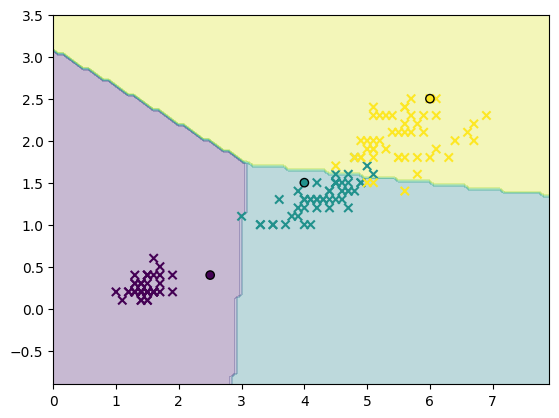

In [8]:
DibuixaClassificador(classificador_svm, X, Y, punts_nous)

Com veiem, s'han generat tres regions per classificar les tres classes. Com podeu comprovar, cada línia que defineix aquestes regions separa dos dels conjunts, pel que podem apreciar el funcionament del mètode one vs all.

In [9]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import numpy as np

# Carreguem el corpus Iris
iris = load_iris(as_frame=True)

# I ens quedem només amb l'alt i ample dels pètals
X = iris.data[["petal length (cm)", "petal width (cm)"]].values

# Classifiquem totes les classes
Y = iris.target

# Creem una llista per emmagatzemar els classificadors
classificadors = []

# Mètode one-vs-all:
# Creem un classificador per a cada classe
for i in np.unique(Y):
    # Creem les etiquetes binàries per a la classe actual
    Y_i = (Y == i)

    # Creem una pipeline per realitzar primer un escalat estàndard
    # i després aplicar un SVC linial amb l'hiperparàmetre de 
    # regularització C=1.
    classificador_svm = make_pipeline(StandardScaler(),
                                      LinearSVC(C=1, random_state=42, dual=True))
    
    # Entrenem el model amb les dades
    classificador_svm.fit(X, Y_i)
    
    # Afegim el classificador a la llista
    classificadors.append(classificador_svm)

In [10]:
def predir(classificadors, X):
    # Obtenim les puntuacions de cada classificador
    puntuacions = [clf.decision_function(X) for clf in classificadors]
    #print(puntuacions)
    # Retornem la classe amb la puntuació més alta
    return np.argmax(puntuacions, axis=0)

In [11]:
# Comprovem els punts nous
punts_nous=[[2.5, 0.4], [4, 1.5], [6, 2.5]]
predir(classificadors, punts_nous)

array([0, 1, 2])

# Provant amb un kernel polinomial


In [12]:
# Importem el corpus i les llibreries

from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Carreguem el corpus Iris
iris=load_iris(as_frame=True)

# I ens quedem només amb l'alt i ample dels pètals
X=iris.data[["petal length (cm)", "petal width (cm)"]].values

# Classifiquem totes les classes
Y = iris.target

# Creem una pipeline per realitzar primer un escalat estàndard
# i després aplicar un SVC linial amb l'hiperparàmetre de 
# regularització C=1.
classificador_svm = make_pipeline(StandardScaler(),
                                  SVC(kernel="poly", degree=2, coef0=1, C=1))

# Entrenem el model amb les dades
classificador_svm.fit(X, Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, coef0=1, degree=2, kernel='poly'))])

In [13]:
# Si ara intentem classificar de nou els punts anteriors:

# Classifiquem tres exemples

punts_nous=np.array([[2.5, 0.4], [4, 1.5], [6, 2.5]])

classificador_svm.predict(punts_nous)

array([0, 1, 2])

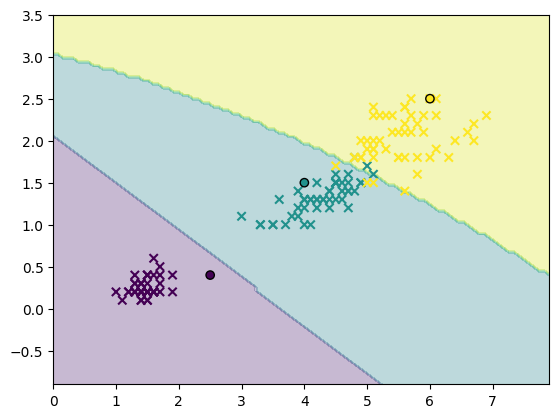

In [14]:
DibuixaClassificador(classificador_svm, X, Y, punts_nous)

# Avaluació del model

Abans d'avaluar aquest model, haurem de tornar a entrenar-lo fent ús només d'un conjunt d'entrenament, i deixant un altre conjunt de mostres només per a test.

Recordem com fer això i integrem-ho amb el codi anterior:

In [15]:
# Importem la llibreria per dividir els conjunts
from sklearn.model_selection import train_test_split
# Importem la llibreria load_iris i carreguem les dades
from sklearn.datasets import load_iris 
iris=load_iris(as_frame=True)

# Ens quedem només amb l'alt i ample dels pètals
X=iris.data[["petal length (cm)", "petal width (cm)"]].values

# Agafem les etiquetes
Y = iris.target

# I dividim el conjunt d'entrenament i de prova al 70%-30%
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


Una vegada hem fet la divisió, creem el classificador i l'entrenem:

In [16]:
# Creem una pipeline per realitzar primer un escalat estàndard
# i després aplicar un SVC linial amb l'hiperparàmetre de 
# regularització C=1.
classificador_svm = make_pipeline(StandardScaler(),
                                  SVC(kernel="poly", degree=2, coef0=1, C=1))

# Entrenem el model amb les dades
classificador_svm.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, coef0=1, degree=2, kernel='poly'))])

I veiem què tal fa les prediccions amb el conjunt de prova. Per a això, llancem les prediccions i les comparem amb les etiquetes:

In [17]:
# Prediccions
prediccions=classificador_svm.predict(X_test)

diferencies=(prediccions == Y_test)

# Hem de reindexar aquestes sèries de Pandas per accedir
# correctament
Y_test_reindexat = Y_test.reset_index(drop=True)
diferencies_reindexat = diferencies.reset_index(drop=True)

# Mostrem les diferencies
print("Etiqueta \t Predicció \t Encert")
print("----------------------------------------------")
for i in Y_test_reindexat.index:
    etiqueta = Y_test_reindexat.loc[i]
    prediccio = prediccions[i]
    encert = diferencies_reindexat.loc[i]
    print(f"{etiqueta} \t {prediccio} \t {encert}")

print("Ressum")

print(f"Encerts: {diferencies.sum()}" )
print(f"Errors: {len(diferencies)-diferencies.sum()}" )


Etiqueta 	 Predicció 	 Encert
----------------------------------------------
1 	 1 	 True
0 	 0 	 True
2 	 2 	 True
1 	 1 	 True
1 	 1 	 True
0 	 0 	 True
1 	 1 	 True
2 	 2 	 True
1 	 1 	 True
1 	 1 	 True
2 	 2 	 True
0 	 0 	 True
0 	 0 	 True
0 	 0 	 True
0 	 0 	 True
1 	 1 	 True
2 	 2 	 True
1 	 1 	 True
1 	 1 	 True
2 	 2 	 True
0 	 0 	 True
2 	 2 	 True
0 	 0 	 True
2 	 2 	 True
2 	 2 	 True
2 	 2 	 True
2 	 2 	 True
2 	 2 	 True
0 	 0 	 True
0 	 0 	 True
0 	 0 	 True
0 	 0 	 True
1 	 1 	 True
0 	 0 	 True
0 	 0 	 True
2 	 2 	 True
1 	 1 	 True
0 	 0 	 True
0 	 0 	 True
0 	 0 	 True
2 	 2 	 True
1 	 1 	 True
1 	 1 	 True
0 	 0 	 True
0 	 0 	 True
Ressum
Encerts: 45
Errors: 0


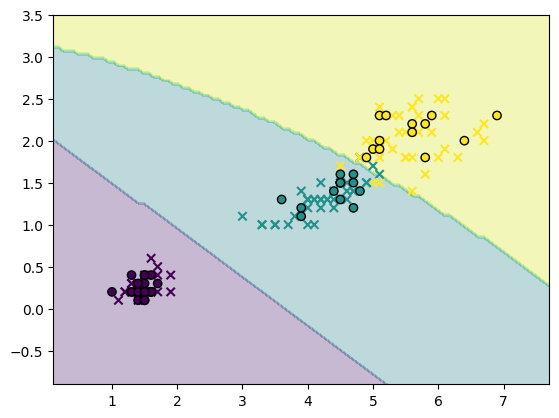

In [18]:
DibuixaClassificador(classificador_svm, X_train, Y_train, X_test)

## Com avaluem els models de classificació?

Per avaluar la qualitat d’un model de classificació, es poden utilitzar diverses mesures i tècniques, algunes de les quals, hem vist de passada durant el curs.

Anem a detallar ara algunes d'aquestes mesures i tècniques i veiem com s'apliquen al nostre exemple.

### Matriu de confusió

Es tracta d'una matriu que mostra la distribució de les prediccions i les etiquetes reals del conjunt de dades. Les **files** representen les **etiquetes reals** i les **columnes** representen les **prediccions**. Els elements de la **diagonal** principal representen les **prediccions correctes**, mentre que els elements **fora de la diagonal** representen les **prediccions incorrectes**.

Veiem com calcular aquesta matriu:

In [19]:
# En primer lloc importem la funció confussion_matrix de sklearn.metrics
from sklearn.metrics import confusion_matrix

# I fem ús d'aquesta funció, proporcionant-li les etiquetes reals i les prediccions
matriu_confusio = confusion_matrix(Y_test, prediccions)

print(matriu_confusio)


[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]


La interpretació d'aquesta matriu és relativament senzilla.

* Es tracta d'una matriu de 3 files x 3 columnes, el que indica que estem treballant amb un problema de classificació amb 3 classes.
* La primera fila es correspon a les etiquetes reals de la primera classe. La primera posició d'aquesta indica les prediccions que el model ha fet per a la primera classe (19 instàncies), la segona columna les prediccions que s'han fet per a la classe 2 (0 instàncies), i la tercera predicció per a la tercera classe (0 instàncies). Per tant, de les 19 instàncies que hi havia de la classe 1, les ha encertades totes.
* Per a la segona fila, el raonament és el mateix, però per a la classe 2, on ha classificat correctament les 13 instàncies que hi havia d'aquesta classe, i no hi ha cal instància mal classificada.
* I per a la tercera fila, el mateix, però aplicat a la tercera classe (13 instàncies ben classificades i 0 mal classificades).

### Precisió

La precisió és la proporció de prediccions positives que són correctes. Es calcula com Vertaders_Positius / ( Vertaders_Positius + Falsos_Positius).

Per calcular-la, fem ús de la funció `precission_score` de `sklearn.metrics`:

In [20]:

from sklearn.metrics import precision_score

# Proporcionem com a arguments les etiquetes, les prediccions, i el tipus de mitjana per 
# tal de calcular la precisió (average)
precisio = precision_score(Y_test, prediccions, average='macro')

print(f"Precisió: {precisio}")

# Els diferents valors que pot prendre average són:
# * None: Esretorna la puntuació de precisió per a cada classe com una llista.
# * micro: Calcula la precisió global comptant el total de vertaders positius, 
#          falsos negatius i falsos positius.
# * macro: Calcula la precisió per a cada etiqueta i obté la seua mitjana no ponderada, 
#          el que fa que no es tinga en compte el desequilibri d'etiquetes.
# * weighted: Calcula la precisió per a cada etiqueta i obté la seua mitjana ponderada
#             per suport (nombre d’instàncies certes per a cada etiqueta), el que 
#             té en compte el desequilibri de les etiquetes.
# * samples: Calcula la precisió aplicant F1_score a cada element de la mostra,
#            i troba la mitjana.

Precisió: 1.0


Com veiem, obtenim una precisió d'1, el que vol dir que ha encertat el 100% de les instàncies.

### Recuperació/Sensibilitat

La recuperació (*Recall*) o sensibilitat és la proporció de positius reals que es prediuen correctament. Es calcula com Vertaders_Positius / (Vertaders_Positius + Falsos_Negatius).

Per obtenir la recuperació, fem ús de la funció `recall_score` de `sklearn.metrics`.

In [21]:
from sklearn.metrics import recall_score

recuperacio = recall_score(Y_test, prediccions, average='macro')

print(f"Recuperació: {recuperacio}")



Recuperació: 1.0


### Precisió vs Sensibilitat

Com hem vist, la precisió i la sensibilitat es calculen de forma semblant, però així com la precisió té en compte la proporció de prediccions positives correctes (VP/(VP+FP)), la sensibilitat el que té en compte és la relació entre predicció de positius reals que es prediuen correctament (VP/(VP+FN)). Una precisió alta indica que el model té un baix percentatge de falsos positius, mentre que una sensibilitat alta indica que el model te un baix percentatge de falsos negatius.

Quin model seria millor? Un que oferira una alta precisió o una alta sensibilitat? Doncs dependrà del context. Per exemple, en un sistema de detecció de spam, seria desitjable una alta precisió per assegurar-nos que els correus electrònics legítims no es marquen com a spam (minimitzar els falsos positius). D’altra banda, en un sistema de detecció de malalties, voldríem una alta sensibilitat per assegurar-nos que detectem tots els possibles casos de la malaltia (minimitzar els falsos negatius).

### Puntuació F1

La puntuació F1 és la mitjana harmònica de la precisió i la recuperació, i dóna una mesura de l'equilibri entre aquestes.

Per calcular-la, fem ús de la funció ` f1_score` de `sklearn.metrics`:

In [22]:
from sklearn.metrics import f1_score

f1 = f1_score(Y_test, prediccions, average='macro')

print(f"F1_Score: {f1}")

F1_Score: 1.0


# Millorant el model

Tot i que hem obtingut uns resultats òptims, anem a revisar les tècniques per seleccionar els millors hiperparàmetres.

Recordem que per tal de fer-ho, tenim dues opcions bé la recerca exhaustiva (GridSearchCV) o la recerca aleatoritzada (RandomizedSearchCV).


In [23]:
# Recerca Exhaustiva

# Importem el GridSearchCV de SKLearn
from sklearn.model_selection import GridSearchCV

# Creem el pipeline
classificador_svm = make_pipeline(StandardScaler(),
                                  SVC())

# Recordeu que aquest mètode ens crea automàticament 
# els noms de cada estimador, que en aquest cas, 
# seran standard_scaler i svc.
# A més, per accedir a les propietats de cada 
# estimador, fem ús de dis guions baixos __

# Establim la llista amb les diferents combinacions
# per als diferents hiperparàmetres de cada estimador
# (en aquest cas svc). Recordem que és una llista
# formada per diccionaris.

param_grid=[
    # Provem Kernels polinomial i Funció de Base Radial
    {'svc__kernel': ["poly"],
     # Provem els graus polinomials 1, 2 i 3 (kernel poly)
     # Aquest paràmetre és el grau del polinomi i determina 
     # la complexitat d'aquest. Graus més alts poden 
     # modelar relacions més complexes, però també poden
     # provocar un sobreajustament si el grau és massa alt.
     'svc__degree': [1, 2, 3],
     # coef0 és el terme independent en el kernel polinomial 
     # i ens permet controlar com d’influent és el grau d’alta
     # dimensió en comparació amb les de baixa dimensió.
     'svc__coef0': [0, 1, 2],
     # Ajustem el paràmetre de regularització, a valors 1, 10 i 100
     'svc__C': [1, 10, 100]},
      {'svc__kernel': ["rbf"],
      'svc__C': [1, 10, 100]},
     ]

# Apliquem el mètode GridSearchCV proporcionant com a paràmetres la 
# pipeline i la llista amb els hiperparàmetres.
# Proporcionarem també els valors:
# * cv=3, per a que establisca 3 grups per a la valodació creuada
# * scoring='f1_macro' per a que utilite F1-Score com a mètrica per 
# avaluar el rendiment del model durant la validació creuada
# Tant aquesta com f1_miro són bones per classificació multiclasse.
# Altres mesures de rendiment com la precisió i la sensibilitat no
# ens aprofiten per a classificació multiclasse.
grid_search=GridSearchCV(classificador_svm, param_grid, cv=3,
                         scoring='f1_macro')

# Entrenem el model amb les dades
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid=[{'svc__C': [1, 10, 100], 'svc__coef0': [0, 1, 2],
                          'svc__degree': [1, 2, 3], 'svc__kernel': ['poly']},
                         {'svc__C': [1, 10, 100], 'svc__kernel': ['rbf']}],
             scoring='f1_macro')

In [24]:
# Per consultar la llista amb els diferents hiperparàmetres, fem:
classificador_svm.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'standardscaler', 'svc', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

In [25]:
# I per tal d'obtenir la millor combinació d'aquests, una vegada 
# fet el procés anterior fem:
grid_search.best_params_

{'svc__C': 100, 'svc__coef0': 1, 'svc__degree': 3, 'svc__kernel': 'poly'}

Com veiem, ens proposa un kernel polinomial de grau 3, amb el terme independent(coef0) a 1 i el paràmetre de regularització a 100.

In [26]:
# Per obtenir el millor estimador, fem:

classificador_final=grid_search.best_estimator_

In [58]:
classificador_final

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=100, coef0=1, kernel='poly'))])

Ara tenim en `classificador_final` el classificador amb aquests resultats. 

Si volem consultar les diferents puntuacions obtingudes per a cada combinació d'hiperparàmetres provats durant la recerca, podem provar el següent codi:

In [27]:
import pandas as pd 

def mostraResultats(metode_recerca):
    # Creem un dataframe amb els resultats
    cv_res = pd.DataFrame(metode_recerca.cv_results_)

    # Els ordenem per la millor puntuació
    cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

    # Millorem visualment el DtaFrame   

    cv_res = cv_res[["param_svc__kernel",
                    "param_svc__degree", 
                    "param_svc__coef0",
                    "param_svc__C",
                    "split0_test_score",
                    "split1_test_score", 
                    "split2_test_score", 
                    "mean_test_score"]]
    score_cols = ["split0", "split1", "split2", "mean_test_f1"]
    cv_res.columns = ["kernel", "degree","coef0", ""] + score_cols

    return cv_res.head()

mostraResultats(grid_search)


,kernel,degree,coef0,,split0,split1,split2,mean_test_f1
23,poly,3.0,1.0,100,0.973162,0.891775,1.000000,0.954979
14,poly,3.0,1.0,10,0.973162,0.917898,0.972174,0.954411
25,poly,2.0,2.0,100,0.973162,0.917898,0.972174,0.954411
29,rbf,NaN,NaN,100,0.973162,0.888889,1.000000,0.954017
0,poly,1.0,0.0,1,0.973162,0.891775,0.972174,0.945703


I podem representar gràficament aquest model amb:

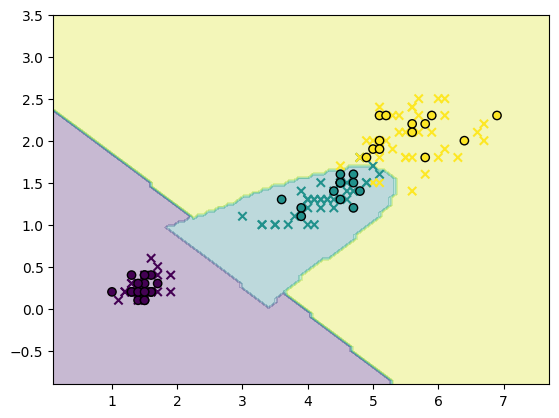

In [28]:
DibuixaClassificador(classificador_final, X_train, Y_train, X_test)

## Recerca aleatoritzada

Hem vist com fer una recerca exhaustiva. Provem ara amb la recerc aleatoritzada amb `RandomizedSearchCV`.

In [29]:
# Importem RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
# Importem la funció randint per generar valors aleatoris de manera uniforme
from scipy.stats import randint

# Establim un diccionari amb els hiperparàmetres que volem combinar
# i proporcionem com a valors la funció randint amb diferents intervals
param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

param_distribs = {'svc__kernel': ["poly", "rbf"],
                  # Provem polinomis de grau 1 a 10
                  'svc__degree': randint(low=1, high=10),
                  # Coeficients de 1 a 10
                  'svc__coef0': randint(low=0, high=10),
                  # Paràmetre de regularització
                  'svc__C': randint(low=0, high=100)}


# Llancem RandomizedSearchCV amb la pipeline completa, els paràmetres que 
# hem establert, amb 10 iteracions com a màxim, 3 subconjunts per a 
# la validació creuada i F1 Score Macro com a mètrica de l'error
rnd_search = RandomizedSearchCV(
    classificador_svm, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='f1_macro', random_state=42)

# Finalment, entrenem l'algorisme amb les dades i etiquetes
rnd_search.fit(X_train, Y_train)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svc', SVC())]),
                   param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000025B8148AE10>,
                                        'svc__coef0': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000025B81488C90>,
                                        'svc__degree': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000025B8143CE50>,
                                        'svc__kernel': ['poly', 'rbf']},
                   random_state=42, scoring='f1_macro')

In [30]:
# Veiem els resultats

mostraResultats(rnd_search)

,kernel,degree,coef0,,split0,split1,split2,mean_test_f1
7,rbf,3,9,90,0.973162,0.888889,1.000000,0.954017
3,rbf,2,4,21,0.973162,0.891775,0.972174,0.945703
4,rbf,2,5,29,0.973162,0.891775,0.972174,0.945703
5,rbf,1,4,59,0.973162,0.888889,0.972174,0.944741
1,poly,8,6,82,1.000000,0.891775,0.916522,0.936099


In [31]:
# I ens quedem amb el millor classificador

classificador_final_rnd=rnd_search.best_estimator_

# Que té els següents hiperparàmetres:

rnd_search.best_params_



{'svc__C': 90, 'svc__coef0': 9, 'svc__degree': 3, 'svc__kernel': 'rbf'}

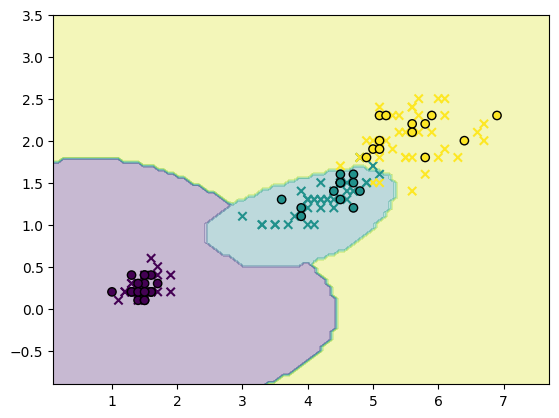

In [32]:
# Gràficament es podria representar amb:

DibuixaClassificador(classificador_final_rnd, X_train, Y_train, X_test)